Kaggle 의 titanic dataset 을 이용하여 탑승자의 생존여부를 판별하는 Logistic Regression 모델을 학습합니다. 이 데이터에 대한 자세한 설명은 아래의 링크를 참고하세요. 우리는 미리 다운로드한 데이터를 로딩합니다.

https://www.kaggle.com/c/titanic/data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = '../mydata/data/datafile/titanic.csv'
titanic = pd.read_csv(data_path, index_col='PassengerId')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


`Name` 과 `Ticket` 은 이용하지 않을 것이며, 값이 길어 불편하므로 이 columns 을 제거합니다. `drop()` 함수를 이용하면 각 columns 이 제거되며, `inplace=True` 로 설정하면 새로운 DataFrame 이 return 되는 것이 아닌, 해당 DataFrame 에 columns 이 제거된 결과가 업데이트 됩니다. `axis=1` 은 `Name` 과 `Ticket` 이 column names 이라는 의미입니다.

In [2]:
titanic.drop(['Name', 'Ticket'], axis=1, inplace=True)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NaN,S
2,1,1,female,38.0,1,0,71.2833,C85,C
3,1,3,female,26.0,0,0,7.9250,NaN,S
4,1,1,female,35.0,1,0,53.1000,C123,S
5,0,3,male,35.0,0,0,8.0500,NaN,S


`DataFrame.info()` 함수를 이용하면 데이터의 개수, type 이 정리되어 보여집니다. 이 데이터는 총 891 명의 승객에 대한 데이터임에도 Age 는 714 개의 값만이 존재합니다. 즉 177 개의 값이 null 이라는 의미입니다. 이후에 이를 제거해봅니다.

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 69.6+ KB


`Embarked` 변수의 의미는 승객들의 탑승 항구이름입니다 (C = Cherbourg, Q = Queenstown, S = Southampton). Categorical variable 이니 dummy variable 로 만듭니다.

In [4]:
print(titanic['Embarked'].value_counts())
embark_dummy = pd.get_dummies(titanic['Embarked'], prefix='port')
embark_dummy.head()

S    644
C    168
Q     77
Name: Embarked, dtype: int64


,port_C,port_Q,port_S
PassengerId,,,
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1
5,0,0,1


`isnull()` 함수를 이용하면 값이 NaN 인 행의 위치가 보입니다.

In [5]:
titanic['Age'].isnull()

PassengerId
1      False
2      False
3      False
4      False
5      False
       ...  
887    False
888    False
889     True
890    False
891    False
Name: Age, Length: 891, dtype: bool

물론 `fillna()` 함수를 이용하여 NaN 을 특정 값으로 변환할 수도 있습니다. 하지만 우리는 연속형 변수를 binning 하여 이산형 변수로 만들 것입니다.

In [6]:
titanic['Age'].fillna(-1, inplace=False)

PassengerId
1      22.0
2      38.0
3      26.0
4      35.0
5      35.0
       ... 
887    27.0
888    19.0
889    -1.0
890    26.0
891    32.0
Name: Age, Length: 891, dtype: float64

20 을 기준으로, 어린이와 성인으로 구분, NaN 은 unknown 으로 변환하였습니다. `titanic['Age']` 을 실행하면 이 Series 의 이름이 'Age' 입니다. 같은 이름 때문에 혼동된다면 age_group.name='AgeGroup' 으로 이름을 변경할 수도 있습니다.

In [7]:
age_group = titanic['Age'] < 20
age_group[age_group] = 'child'
age_group[titanic['Age'] >= 20] = 'adult'
age_group[titanic['Age'].isnull()] = 'unknown'
age_group.name = 'AgeGroup'
age_group

PassengerId
1        adult
2        adult
3        adult
4        adult
5        adult
        ...   
887      adult
888      child
889    unknown
890      adult
891      adult
Name: AgeGroup, Length: 891, dtype: object

age_group 은 이산형 변수이므로 이 역시 dummy variables 로 변형합니다.

In [8]:
age_dummy = pd.get_dummies(age_group, prefix='Age')

In [9]:
pclass_dummy = pd.get_dummies(titanic['Pclass'], prefix='Pclass')

성별은 0, 1 로 그 값을 변화합니다.

In [10]:
titanic['Sex'] = titanic['Sex'].map({'female':1, 'male':0})

지금까지 만든 변수들을 모두 종합합니다.

In [11]:
titanic = pd.concat([titanic, pclass_dummy, embark_dummy, age_dummy], axis=1)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,port_C,port_Q,port_S,Age_adult,Age_child,Age_unknown
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,NaN,S,0,0,1,0,0,1,1,0,0
2,1,1,1,38.0,1,0,71.2833,C85,C,1,0,0,1,0,0,1,0,0
3,1,3,1,26.0,0,0,7.9250,NaN,S,0,0,1,0,0,1,1,0,0
4,1,1,1,35.0,1,0,53.1000,C123,S,1,0,0,0,0,1,1,0,0
5,0,3,0,35.0,0,0,8.0500,NaN,S,0,0,1,0,0,1,1,0,0


학습데이터를 만드는 `make_train_data()` 함수를 만듭니다. 데이터의 크기를 확인하기 위하여 이 함수를 만들 때마다 print() 구문이 실행되도록 구현합니다. str.split() 을 실행하면 띄어쓰기를 기준으로 str 을 분리합니다. `split()` 안에 분리할 글자를 입력할 수도 있습니다. list of str 보다 간편하게 input_names 를 만들 수 있습니다.

In [12]:
'caba*baa*bbabb'.split('*')

['caba', 'baa', 'bbabb']

In [13]:
def make_train_data(input_names, output_name):
    X = titanic[input_names].to_numpy()
    y = titanic[output_name].to_numpy()
    print(f'shape of X = {X.shape}')
    print(f'shape of y = {y.shape}')
    return X, y

input_names = 'Pclass_1 Pclass_2 Pclass_3 Sex SibSp Parch Fare port_C port_Q port_S Age_adult Age_child Age_unknown'.split()
output_name = 'Survived'

X, y = make_train_data(input_names, output_name)

shape of X = (891, 13)
shape of y = (891,)


Logistic Regression 을 학습하고, coefficient 를 확인합니다. 1등객 손님들이 생존율이 높고 3등객 손님들은 사망확률이 높았네요. 성별과 나이에 따라서도 차이가 있습니다. 여성이 남성보다, 아이가 어른보다 생존율이 높습니다.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000)
model.fit(X, y)

print(f'intercept   : {model.intercept_[0]:.4}')
for i, coef in enumerate(model.coef_[0]):
    print(f'{input_names[i]:12}: {coef:.4}')

intercept   : -0.8264
Pclass_1    : 0.7623
Pclass_2    : 0.1631
Pclass_3    : -0.9055
Sex         : 2.607
SibSp       : -0.2939
Parch       : -0.1196
Fare        : 0.003346
port_C      : 0.1146
port_Q      : 0.06193
port_S      : -0.3716
Age_adult   : -0.2545
Age_child   : 0.5935
Age_unknown : -0.3191


생존 확률도 `predict_proba()` 를 통하여 확인할 수 있습니다.

In [15]:
y_prob = model.predict_proba(X)
y_prob[:5]

array([[0.93262461, 0.06737539],
       [0.08723812, 0.91276188],
       [0.43149182, 0.56850818],
       [0.14175667, 0.85824333],
       [0.91141991, 0.08858009]])

## Question

Logistic Regression 의 classification 은 확률이 0.5 를 넘으면 1, 그렇지 않으면 0 으로 이뤄집니다. 만약 이 threshold 를 [0,3, 0.4, 0.5, 0.6, 0.7] 로 조절하면 각각 precision, recall, f1-score, accuracy 가 어떻게 변화할까요? `y_prob` 와 `numpy.where()` 을 이용하여 각각의 값을 계산하고, 그 결과를 이해하기 쉬운 plots 으로 그려봅니다.

In [16]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


def predict_manual(y_prob, threshold):
    y_pred = np.zeros(y_prob.shape[0], dtype=np.int)
    y_pred[np.where(y_prob[:,1] >= threshold)[0]] = 1
    return y_pred

def evaluate(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

threshold = np.linspace(0.2, 0.8, 30)
performance = np.zeros((threshold.shape[0], 4))
for i, t in enumerate(threshold):
    y_pred = predict_manual(y_prob, t)
    perf = np.array(evaluate(y, y_pred))
    performance[i] = perf


np.set_printoptions(precision=5)
print('[precision recall f1      accuracy]')
print(performance)

[precision recall f1      accuracy]
[[0.56381 0.8655  0.68281 0.69136]
 [0.56977 0.85965 0.68531 0.69697]
 [0.62366 0.84795 0.71871 0.74523]
 [0.6269  0.84503 0.7198  0.74747]
 [0.63158 0.84211 0.7218  0.75084]
 [0.63274 0.83626 0.7204  0.75084]
 [0.64103 0.80409 0.71336 0.75196]
 [0.65854 0.78947 0.71809 0.76207]
 [0.6828  0.74269 0.71148 0.7688 ]
 [0.69697 0.73977 0.71773 0.77666]
 [0.71388 0.73684 0.72518 0.78563]
 [0.71552 0.72807 0.72174 0.78451]
 [0.73433 0.7193  0.72674 0.79237]
 [0.75    0.71053 0.72973 0.79798]
 [0.77076 0.67836 0.72162 0.7991 ]
 [0.79239 0.66959 0.72583 0.80584]
 [0.80645 0.65789 0.72464 0.80808]
 [0.81319 0.64912 0.72195 0.80808]
 [0.85772 0.61696 0.71769 0.81369]
 [0.85892 0.60526 0.71012 0.81033]
 [0.87179 0.59649 0.70833 0.81145]
 [0.88158 0.58772 0.70526 0.81145]
 [0.88546 0.58772 0.7065  0.81257]
 [0.90547 0.53216 0.67035 0.7991 ]
 [0.90355 0.52047 0.66048 0.79461]
 [0.90769 0.51754 0.65922 0.79461]
 [0.91573 0.47661 0.62692 0.78227]
 [0.93293 0.44737 0

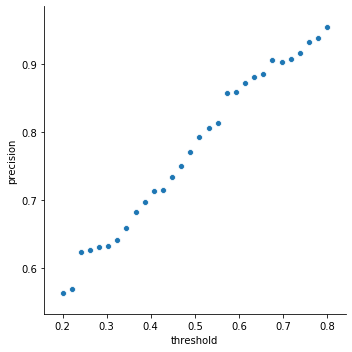

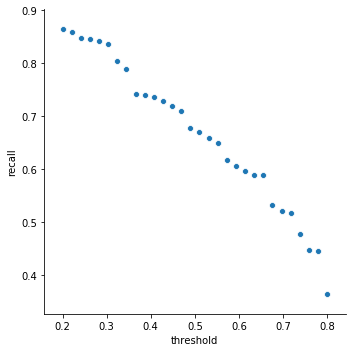

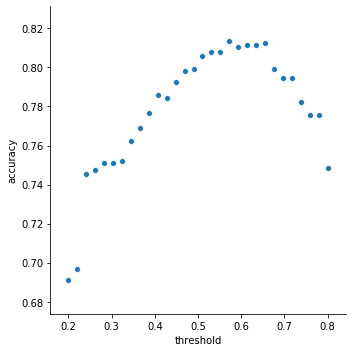

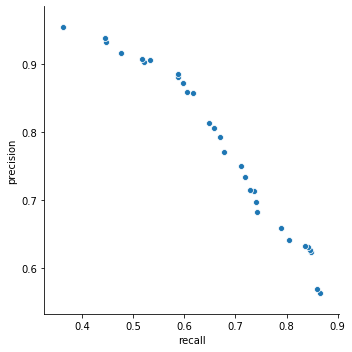

In [17]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({
    'threshold': threshold,
    'precision': performance[:,0],
    'recall': performance[:,1],
    'f1': performance[:,2],
    'accuracy': performance[:,3]
})

g_pt = sns.relplot(x="threshold", y="precision", data=df)
g_rt = sns.relplot(x="threshold", y="recall", data=df)
g_at = sns.relplot(x="threshold", y="accuracy", data=df)
g_pr = sns.relplot(x='recall', y='precision', data=df)